In [39]:
# Importation des données
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.regularizers import l2

In [40]:
# Chargement des données et suppression des lignes manquantes
df = pd.read_csv('IMDB Dataset.csv').dropna()

# Nettoyage de texte : suppression des balises HTML "<br />"
df['review'] = df['review'].str.replace('<br />', ' ', regex=False)

# Afficher un aperçu des données
print(df.head())
df.info()

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production.   The filming t...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [41]:
# Paramètres pour le tokeniseur et le traitement des séquences
max_words = 10000  # Nombre maximal de mots à considérer
maxlen = 100       # Longueur fixe des séquences textuelles

# Initialisation du tokenizer pour transformer le texte en séquences d'entiers
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

# Padding des séquences pour obtenir des vecteurs de longueur égale
X = pad_sequences(sequences, maxlen=maxlen)

# Encodage des labels (0 pour négatif, 1 pour positif)
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [42]:
# Division des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [43]:
# Correction : Passe les poids de classe sous forme de dictionnaire
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [44]:
# Création du modèle avec régularisation L2, et utilisation de LSTM pour une meilleure capture des relations temporelles
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, embeddings_regularizer=l2(0.001)),  # Régularisation réduite
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001)),  # LSTM au lieu de SimpleRNN, plus performant pour les séquences longues
    Dropout(0.5),  # Dropout pour prévenir le surapprentissage
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

In [45]:
# Compilation du modèle avec Adam et une réduction du learning rate pour un entraînement plus stable
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# Entraînement du modèle sans early stopping avec les poids de classe
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights_dict)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8541 - loss: 0.4440 - val_accuracy: 0.8553 - val_loss: 0.4213
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.8619 - loss: 0.4189 - val_accuracy: 0.8566 - val_loss: 0.4121
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.8777 - loss: 0.3825 - val_accuracy: 0.8621 - val_loss: 0.3967
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.8853 - loss: 0.3636 - val_accuracy: 0.8474 - val_loss: 0.4450
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8907 - loss: 0.3538 - val_accuracy: 0.8586 - val_loss: 0.4125


In [49]:
# Prédiction sur les données de validation
y_pred = model.predict(X_val)
y_pred = np.round(y_pred)  # Conversion des prédictions en 0 ou 1

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [50]:
# Calcul de la précision
accuracy = accuracy_score(y_val, y_pred)
print("Précision:", accuracy)

Précision: 0.8586


In [52]:
# Génération de la matrice de confusion
conf_matrix = confusion_matrix(y_val, y_pred)
print("Matrice de confusion:\n", conf_matrix)

Matrice de confusion:
 [[4083  946]
 [ 468 4503]]


In [53]:
# Récupération de l'historique de l'entraînement pour le traçage
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


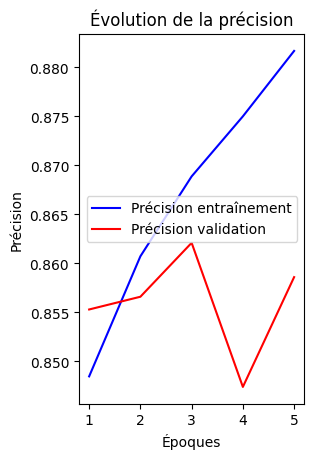

In [55]:
# Graphique de la précision
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision validation')
plt.title('Évolution de la précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()


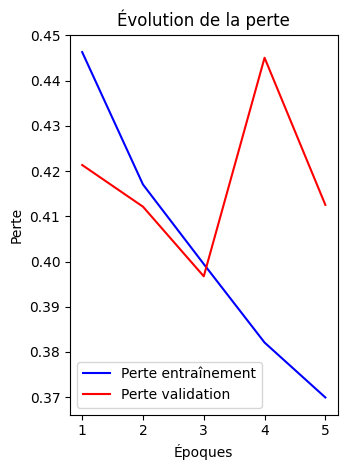

In [56]:
# Graphique de la perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte validation')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()  # Ajustement de l'affichage des sous-graphiques
plt.show()
